In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune
from torchsummary import summary

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class ScaledConvLayer(nn.Module):
  def __init__(self, dim, conv_layer):
    super().__init__()
    self.scale_factors = nn.Parameter(torch.rand(dim, requires_grad=True))
    self.conv_layer = conv_layer

  def forward(self, x):
    self.conv_layer.weight.mul(F.normalize(self.scale_factors))
    return self.conv_layer(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

import numpy as np

apply_alpha = False
#__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet164','resnet1202']
__all__ = ['resnet20']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class TargetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(TargetBlock, self).__init__()
        self.alpha1 = nn.Parameter(torch.rand([planes,1,1,1], requires_grad=True))
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.alpha2 = nn.Parameter(torch.rand([planes,1,1,1], requires_grad=True))
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.alpha_sc = nn.Parameter(torch.rand([self.expansion * planes,1,1,1], requires_grad=True))
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        self.conv1.weight.mul(F.softmax(self.alpha1, dim=0))
        self.conv2.weight.mul(F.softmax(self.alpha2, dim=0))
        if 'Conv2d' in str(self.shortcut):
            self.shortcut[0].weight.mul(F.softmax(self.alpha_sc, dim=0))
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class TargetResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(TargetResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = ScaledConvLayer([16, 1, 1, 1], nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False))
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    def alphaL2(self):
        l2norm = 0
        
        return l2norm
#
def resnet20():
    return TargetResNet(TargetBlock, [3, 3, 3])

https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ScaledConvLayer([6, 1, 1, 1], nn.Conv2d(3, 6, 5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = ScaledConvLayer([16, 1, 1, 1], nn.Conv2d(6, 16, 5))
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = resnet20()


In [ ]:
threshnet_spoof = torch.tensor([0.7, 0.7])


In [ ]:
import torchvision

from google.colab import drive

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='.\data', train=True,
                                           download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.\data', train=False,
                                        download=True, transform=transform)

testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .\data/cifar-10-python.tar.gz to .\data
Files already downloaded and verified


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

NameError: ignored

In [ ]:
PATH = './pretrained_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = resnet20()

net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

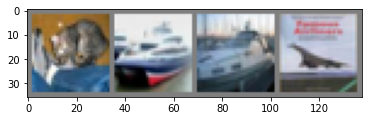

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testLoader)
images, labels = dataiter.next()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [ ]:
class SamplerPruneLayer(prune.BasePruningMethod):
  PRUNING_TYPE = 'unstructured'
  def __init__(self, thresh):
    self.thresh = thresh

  def compute_mask(self, al, default_mask):
    nl = al - torch.log(torch.rand(al.size()))
    nl = F.softmax(nl, dim = 0)
    c = 1
    for x in range(al.size()[0]):
        x, _ = torch.topk(nl, c, dim = 0)
        s = torch.sum(x)
        c = c + 1
        if(s > self.thresh):
          break
    _, idx = torch.topk(al, c, dim=0)
    mask = torch.zeros(al.size())
    mask[idx] = 1
    return mask

def prune_layer(module, name, thresh):
  SamplerPruneLayer.apply(module, name, thresh)
  return module

In [ ]:
def update_net(module, name):
  old_weights = torch.clone(getattr(module, name+"_orig"))
  old_mask = torch.clone(getattr(module, name+"_mask")) < 1
  prune.remove(module, name)
  with torch.no_grad():
    layer = getattr(module, name)
    layer[old_mask] = old_weights[old_mask]

In [ ]:
num_subnets = 6
loss_tracker = []
thresh1, thresh2 = (0.7, 0.7)

for j in range(0, num_subnets):
    print("*--------Sample and Train Start--------*")
    print("Sampling {}th subnetwork".format(i+1))
    prune_layer(net.conv1, 'scale_factors', thresh1)
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                loss_tracker.append(running_loss / 2000)
                running_loss = 0.0
    print("Saving network weights")
    PATH = './pretrained_net_subnet{}.pth'.format(j)
    torch.save(net.state_dict(), PATH)
    print("Mapping network weights back to larger network")
    update_net(net.conv1, 'scale_factors')
    print("*--------Sample and Train Done--------*")

*--------Sample and Train Start--------*


NameError: ignored

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        # calculate outputs by r`unning images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
net = Net()
#prune layer has no lasting impact
#these two lines add the attributes needed to load the state dict
prune_layer(net.conv1, "scale_factors", 0.1)

net.load_state_dict(torch.load(PATH))

In [ ]:
conv_elim_1 = int(torch.sum(net.conv1.scale_factors_mask==0))
print("{} convolutions are eliminated from layer 1".format(conv_elim_1))


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        # calculate outputs by r`unning images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))